<a href="https://colab.research.google.com/github/kasvinatirumal/wdrp_wi25/blob/main/call-and-put.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pricing Call and Put Options for Microsoft Stock using the Black-Scholes Model

In [1]:
pip install yahoo_fin

In [2]:
from yahoo_fin import options
import yfinance as yf
from datetime import datetime
import pandas as pd
import math
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

## Obtaining Microsoft Stock Data from Yahoo Finance

In [3]:
# creates a Ticker object for Microsoft stock (MSFT)
msft = yf.Ticker("MSFT")

# gets expiration_dates for options
expiration_dates = msft.options
print(expiration_dates)

('2025-02-28', '2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-04-04', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')


## Pricing Call Options

In [4]:
# Fetch call option data for a specific expiration date
call_options = options.get_calls("MSFT", "2025-08-15")
print(call_options)

/usr/local/lib/python3.11/dist-packages/yahoo_fin/options.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(requests.get(site, headers=headers).text)


          Contract Name Last Trade Date (EST)  Strike  Last Price     Bid  \
0   MSFT250815C00200000     2/14/2025 2:04 PM     200      212.00  210.60   
1   MSFT250815C00210000   12/27/2024 11:15 AM     210      224.43  211.60   
2   MSFT250815C00225000    10/29/2024 3:27 PM     225      215.60  205.00   
3   MSFT250815C00230000      1/6/2025 3:43 PM     230      203.40  182.15   
4   MSFT250815C00235000      1/6/2025 3:50 PM     235      198.85  178.25   
..                  ...                   ...     ...         ...     ...   
77  MSFT250815C00610000      2/5/2025 9:37 AM     610        0.56    0.00   
78  MSFT250815C00615000    2/19/2025 11:47 AM     615        0.40    0.36   
79  MSFT250815C00620000     2/11/2025 9:30 AM     620        0.44    0.00   
80  MSFT250815C00640000     2/21/2025 3:48 PM     640        0.25    0.21   
81  MSFT250815C00660000     2/21/2025 9:30 AM     660        0.22    0.12   

       Ask  Change % Change Volume  Open Interest Implied Volatility  
0   

In [5]:
df1 = pd.DataFrame(call_options)
df1.to_csv('call_options.csv', index=False)

In [6]:
calls = df1.copy()
calls.head()

,Contract Name,Last Trade Date (EST),Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,MSFT250815C00200000,2/14/2025 2:04 PM,200,212.00,210.60,214.85,0.0,0.00%,4,7,71.23%
1,MSFT250815C00210000,12/27/2024 11:15 AM,210,224.43,211.60,212.95,0.0,0.00%,15,15,92.76%
2,MSFT250815C00225000,10/29/2024 3:27 PM,225,215.60,205.00,207.45,0.0,0.00%,1,0,102.41%
3,MSFT250815C00230000,1/6/2025 3:43 PM,230,203.40,182.15,185.90,0.0,0.00%,15,33,63.21%
4,MSFT250815C00235000,1/6/2025 3:50 PM,235,198.85,178.25,181.90,0.0,0.00%,41,31,64.11%


In [7]:
calls.describe()

,Strike,Last Price,Bid,Ask,Change,Open Interest
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,426.890244,55.397927,52.257927,53.879268,-1.069878,339.817073
std,121.978647,65.315920,61.714131,62.915593,1.961519,681.461558
min,200.000000,0.220000,0.000000,0.210000,-6.800000,0.000000
25%,326.250000,2.717500,2.250000,2.395000,-1.910000,45.000000
50%,427.500000,22.750000,22.500000,24.800000,0.000000,122.500000
75%,528.750000,93.412500,91.612500,94.950000,0.000000,414.750000
max,660.000000,224.430000,211.600000,214.850000,3.770000,5271.000000


In [8]:
calls["Implied Volatility"] = calls["Implied Volatility"].str[:-1].astype(float)
calls = calls[calls["Implied Volatility"] != 0]

We first calculate the price of a call option on Microsoft stock expiring on 2025-08-15, using the median strike price and volatility from the calls dataset. Before proceeding, we define the following variables:

- K: Strike price in US dollars
- S: Stock price in US dollars
- T: Time to expiration in number of years
- r: Risk-free rate (based on current yield on 6 month trasury bill)
- v: Volatility
- C: Price of option

In [9]:
strike_price = calls["Strike"].median()
imp_vol = calls["Implied Volatility"].median()
print(f"strike_price = {strike_price}, imp_vol ={imp_vol}")

strike_price = 427.5, imp_vol =29.060000000000002


In [10]:
S = 408.43	# closing stock price on Feb 14
K = strike_price
T = 0.5 # 6 months
r = 0.0434 # current yield on 6 month treasury bill (4.34%)
v = imp_vol/100

Formula for Call Options:
$$d_1 = \frac{1}{v \cdot \sqrt{T}} * \left[ln\left(\frac{S}{K}\right) + \left(r + \frac{1}{2}v^2\right) \cdot T\right]$$
$$d_2 = d_1 - v \cdot \sqrt{T}$$
$$F =  S \cdot N[d_1] - e^{−rT} \cdot K \cdot N[d_2]$$

In [11]:
def calc_call_option_price(S, K, T, r, v):
  d1 = (math.log(S/K) + (r + 0.5 * v**2) * T) / (v * math.sqrt(T))
  d2 = d1 - v * math.sqrt(T)
  F = S * norm.cdf(d1) - math.exp(-r * T) * K * norm.cdf(d2)
  return F

In [12]:
calc_call_option_price(S, K, T, r, v)

29.10953356450932

Next, we compute the theoretical price for each option in the calls dataset and add it as a new column.

In [13]:
calls["Theoretical Price"] = calls.apply(
    lambda row: calc_call_option_price(S, row["Strike"], T, r, row["Implied Volatility"]/100),
    axis=1
)

Text(0.5, 1.0, 'Scatterplot of Implied Volatility vs Theoretical Call Option Prices')

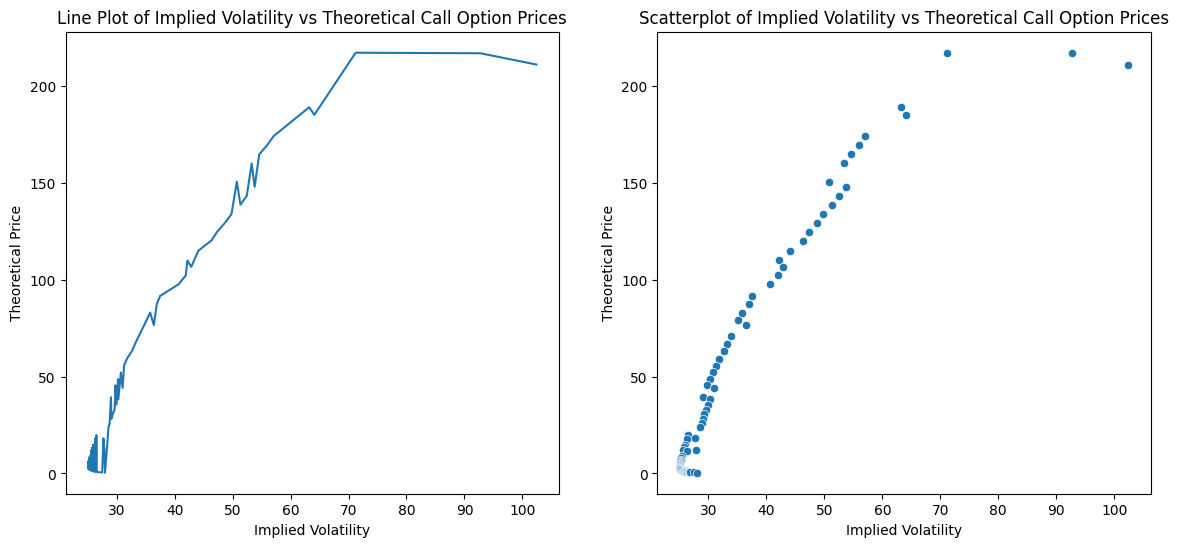

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(x="Implied Volatility", y="Theoretical Price", data=calls, ax=axs[0])
axs[0].set_title("Line Plot of Implied Volatility vs Theoretical Call Option Prices")

sns.scatterplot(x="Implied Volatility", y="Theoretical Price", data=calls, ax=axs[1])
axs[1].set_title("Scatterplot of Implied Volatility vs Theoretical Call Option Prices")

## Pricing Put Options

In [15]:
put_options = options.get_puts("MSFT", "2025-08-15")

/usr/local/lib/python3.11/dist-packages/yahoo_fin/options.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(requests.get(site, headers=headers).text)


In [16]:
df2 = pd.DataFrame(put_options)
df2.to_csv('put_options.csv', index=False)

In [17]:
puts = df2.copy()

In [18]:
puts["Implied Volatility"] = puts["Implied Volatility"].str[:-1].astype(float)
puts = puts[puts["Implied Volatility"] != 0]

Formula for Put Options:
$$F = e^{−r(T −t)} \cdot K \cdot N[d_2] - S \cdot N[d_1]$$

In [19]:
def calc_put_option_price(S, K, T, r, v):
  d1 = (math.log(S/K) + (r + 0.5 * v**2) * T) / (v * math.sqrt(T))
  d2 = d1 - v * math.sqrt(T)
  F = math.exp(-r * T) * K * norm.cdf(-d2) - S * norm.cdf(-d1)
  return F

In [20]:
puts["Theoretical Price"] = puts.apply(
    lambda row: calc_put_option_price(S, row["Strike"], T, r, row["Implied Volatility"]/100),
    axis=1
)

Text(0.5, 1.0, 'Scatterplot of Implied Volatility vs Theoretical Put Option Prices')

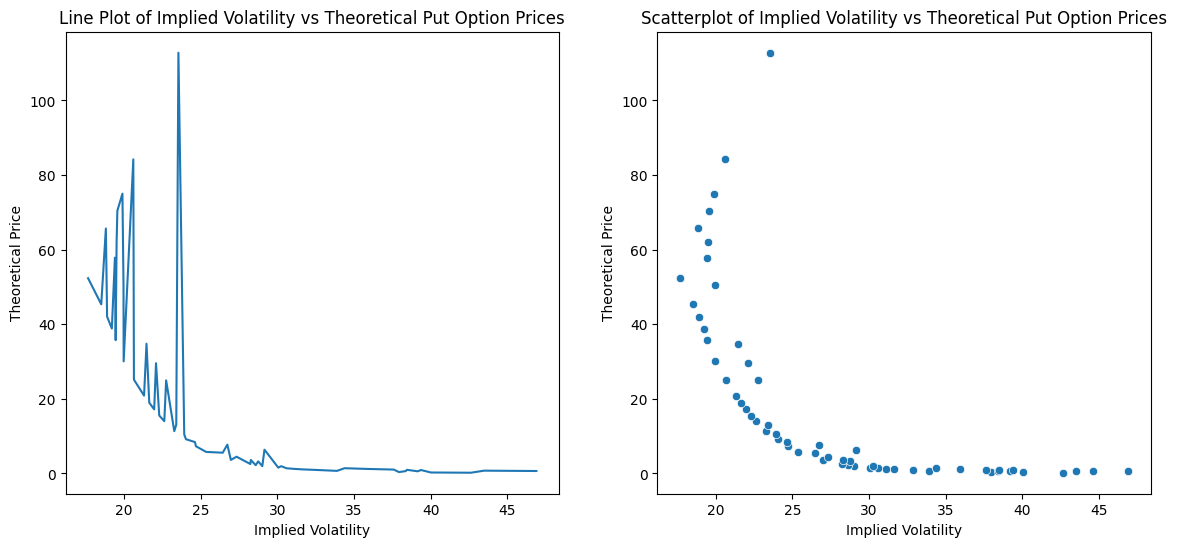

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(x="Implied Volatility", y="Theoretical Price", data=puts, ax=axs[0])
axs[0].set_title("Line Plot of Implied Volatility vs Theoretical Put Option Prices")

sns.scatterplot(x="Implied Volatility", y="Theoretical Price", data=puts, ax=axs[1])
axs[1].set_title("Scatterplot of Implied Volatility vs Theoretical Put Option Prices")